# Object Removal and Impainting Project
Participants:

- 
- 
- Alexei Ivanov (20917576)

## Description



# Setup
Run the following cells to setup your environment

In [1]:
# install dependencies
!pip install -r requirements.txt

In [150]:
import torch
import scipy
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from PIL import Image
from copy import deepcopy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset
To train the model we decided to use OpenAI's Country211 Dataset. You can read more about the dataset here [https://github.com/openai/CLIP/blob/main/data/country211.md](https://github.com/openai/CLIP/blob/main/data/country211.md).

The following cell will download the dataset which is around 20GB

## Download and Create Dataset
We download the country211 dataset using pytorch, but since our objective is slightly different we need to create our own custom dataset and reload the data. We call ou custom dataset the country212 dataset.

In [137]:
# download data
train_dataset = torchvision.datasets.Country211("country211/", split="train", download=True)
val_dataset = torchvision.datasets.Country211("country211/", split="valid", download=True)
test_dataset = torchvision.datasets.Country211("country211/", split="test", download=True)

In [139]:
# script to copy data into desired location and format
import os
import shutil

if not os.path.exists("country212"): os.mkdir("country212")
if not os.path.exists("country212/train"): os.mkdir("country212/train")
if not os.path.exists("country212/valid"): os.mkdir("country212/valid")
if not os.path.exists("country212/test"): os.mkdir("country212/test")

def flatten_dir(mode="train"):
    for dir in os.listdir(f"country211/country211/{mode}"):
        for file in os.listdir(f"country211/country211/{mode}/{dir}"):
            shutil.copy(f"country211/country211/{mode}/{dir}/{file}", f"country212/{mode}")

flatten_dir("train")
flatten_dir("valid")
flatten_dir("test")

In [140]:
# assert script worker and all data is present
assert len(os.listdir("country212/train")) == len(train_dataset)
assert len(os.listdir("country212/valid/")) == len(val_dataset)
assert len(os.listdir("country212/test/")) == len(test_dataset)

In [191]:
class country212Dataset(Dataset):

    def __init__(self, root_dir, transforms=None) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.transforms = transforms
        self.all_imgs = sorted(os.listdir(root_dir))
        

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, index):
        """
        This method is supposed to return training_img, correct_img. To generate this we do the following
        
            1) load the image
            2) apply given transforms to the image
            3) create a deep copy of the image which is going to be used as the ground truth image
            4) crop the center (CENTER_CROP_OUT_SIZE, CENTER_CROP_OUT_SIZE)
        """
        # (1) load image
        img_path = os.path.join(self.root_dir, self.all_imgs[index])
        image = Image.open(img_path).convert("RGB")

        # (2) apply given transforms to the image
        transformed_img = self.transforms(image) if self.transforms else image

        # (3) create deep copy of image
        ground_truth_image = deepcopy(transformed_img)

        # (4) crop the center
        #       an assumption here is that the image is 300x300 which is true because we constructed the transforms
        transformed_img[:, 100:200, 100:200] = 0

        return transformed_img, ground_truth_image

In [203]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomResizedCrop(size=(300, 300), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

my_train_dataset = country212Dataset("country212/train/", transforms=transforms)
my_val_dataset = country212Dataset("country212/valid/", transforms=transforms)
my_test_dataset = country212Dataset("country212/test", transforms=transforms)

/home/alex/miniconda3/envs/school/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [204]:
assert len(my_train_dataset) == len(train_dataset)
assert len(my_val_dataset) == len(val_dataset)
assert len(my_test_dataset) == len(test_dataset)

## Explore Dataset

In [205]:
item = my_test_dataset[0]
print(item[0].shape, item[1].shape)

torch.Size([3, 300, 300]) torch.Size([3, 300, 300])


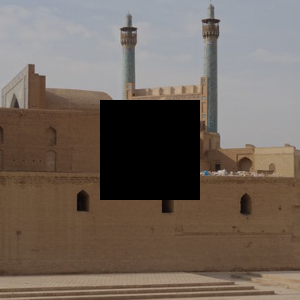

In [206]:
# train image 
v2.ToPILImage()(item[0])

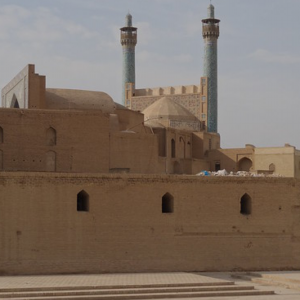

In [208]:
# ground truth image
v2.ToPILImage()(item[1])

In [ ]:
# from now on we use our implementation of the dataset
train_dataset, val_dataset, test_dataset = my_train_dataset, my_val_dataset, my_test_dataset

## Setup Dataloader

In [84]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)